# Setup

## Load and install packages

In [1]:
%%capture

# !pip install PyMuPDF
# !pip install nltk
# !pip install ocrmypdf
# !pip install pytesseract
# !pip install pngquant
# !pip install pyarrow 
# !pip install fastparquet
# !pip install datasets
# !pip install icecream
# !pip install fastparquet


In [2]:
from tqdm.auto import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import fitz 
from PIL import Image
import re
import pngquant
from unidecode import unidecode
import torch
import evaluate

%matplotlib inline

## PDF Helper Functions

In [3]:
def get_pdf(path):
    '''Reads a PDF file and returns a PdfDocument object'''
    doc = fitz.open(path)
    return doc

def render(page):
    '''Render a page to a PIL image.'''
    bitmap = page.render(
        scale = 1,    # 72dpi resolution
        rotation = 0, # no additional rotation
    )
    return bitmap.to_pil()

# cleanup content using regex:
def clean_characters(text):
    text = unidecode(text) # convert to ascii
    text = re.sub(r"[^a-zA-Z0-9.£$€']+", ' ', text) # strategy 1: keep numbers
    # text = re.sub(r"[^a-zA-Z:.£$€'\n]+", ' ', text) ## strategy 2: remove numbers and %
    text = ' '.join([w for w in text.split() if len(w)>1] )
    return text

def extract_content_from_id(file_id: str) -> str :    
    # extract filename and page
    items = file_id.split('.')
    filename = '.'.join(items[:2])
    page_num = int(items[-1])-1
    
    # load pdf, select page, and extract its content
    filepath = os.path.join(report_path, filename) #path to the report
    doc = get_pdf(filepath) # load the pdf
    page = doc.load_page(page_num) # select the page from the pdf
    content = page.get_text("text", sort = True, flags=fitz.TEXT_INHIBIT_SPACES) # extract the text from the page
    content = unidecode(content) # convert to ascii
    content = clean_characters(content) # replace unrecognized characters
    return content

def render_content_from_id(file_id: str) -> str :    
    # extract filename and page
    items = file_id.split('.')
    filename = '.'.join(items[:2]) # reconstruct the report name
    page_num = int(items[-1])-1
    
    # load pdf, select page, and extract its content
    filepath = os.path.join(report_path, filename) #path to the report
    doc = get_pdf(filepath) # load the report pdf
    dpi = 150  # set the dpi
    mat = fitz.Matrix(dpi / 72, dpi / 72)  # sets zoom factor
    pix = doc[page_num].get_pixmap(matrix=mat)
    img_page = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    return img_page

## Set path for folder

- choose one of the following blocks: online if run directly on Kaggle, local if data downloaded

In [4]:
# # kaggle online path
# basepath = "/kaggle/input/oxml2023mlcases-esg-classifier/data/"
# report_path = os.path.join(basepath, "reports")
# label_path = os.path.join(basepath, "labels.csv")

In [5]:
# local data path 

# current working directory, go up 1 level
basepath = Path.cwd().parents[0]

# build get path function, input folder name (as a list) and file name (optional), return the path
def get_path(folder_name: list, file_name=None):
    path = Path(basepath)
    for folder in folder_name:
        path = path / folder
    if file_name:
        path = path / file_name
    return path

# report path
report_path = get_path(["data", "reports"])

# label path
label_path = get_path(["data"], "labels.csv")

# output path
output_path = get_path([], "output")

# submit sample path
submit_path = get_path([], "sample_submission.csv")

In [6]:

print("Report path: ", report_path)
print("Label path: ", label_path)

Report path:  /Users/mbp14/Desktop/GoogleDrive/Kaggle/ESG_classifier/data/reports
Label path:  /Users/mbp14/Desktop/GoogleDrive/Kaggle/ESG_classifier/data/labels.csv


# Load Data

In [7]:
# read label file to get id and class
df = pd.read_csv(label_path)

# check duplicates id
print("Number of duplicated id: ", df.duplicated(subset=['id']).sum())

# slice duplicated id, all entries with duplicated id
df_duplicate = df[df.duplicated(subset=['id'], keep=False)].sort_values(by=['id'])
df_duplicate # duplicates have conflicting labels, due to nature of the pages

# drop the duplicates (keep the first entry)
df = df.drop_duplicates(subset=['id'], keep='first').sort_values(by=['id'])

Number of duplicated id:  5


### Extract content from pdf pages

- for each row, we grab the 'id', which contains a report_id and a page number
- use a function to load the correct page from the pdf report, and extract the content

The hydrogen opportunity before us has proven potential which is why NJNG has initiated power to gas project in our service territory We are developing this renewable hydrogen project at our Howell NJ facility and we expect to reach commercial operation in 2021 With landfills and other feedstocks being utilized RNG can have real impact on reducing carbon emissions in the State ICF estimates that by 2050 RNG can represent nearly half of New Jersey's natural gas usage Nationally ICF has estimated that enough RNG can be produced to meet nearly all home heating needs The team is currently analyzing multiple opportunities related to RNG and we expect these discussions to progress in the coming year Our power to gas project will be used to study blending capabilities and technology create awareness with regulators and policymakers and build expertise to allow us to scale as the market continues to develop We have great confidence we will continue to deliver on the clean energy opportunities 

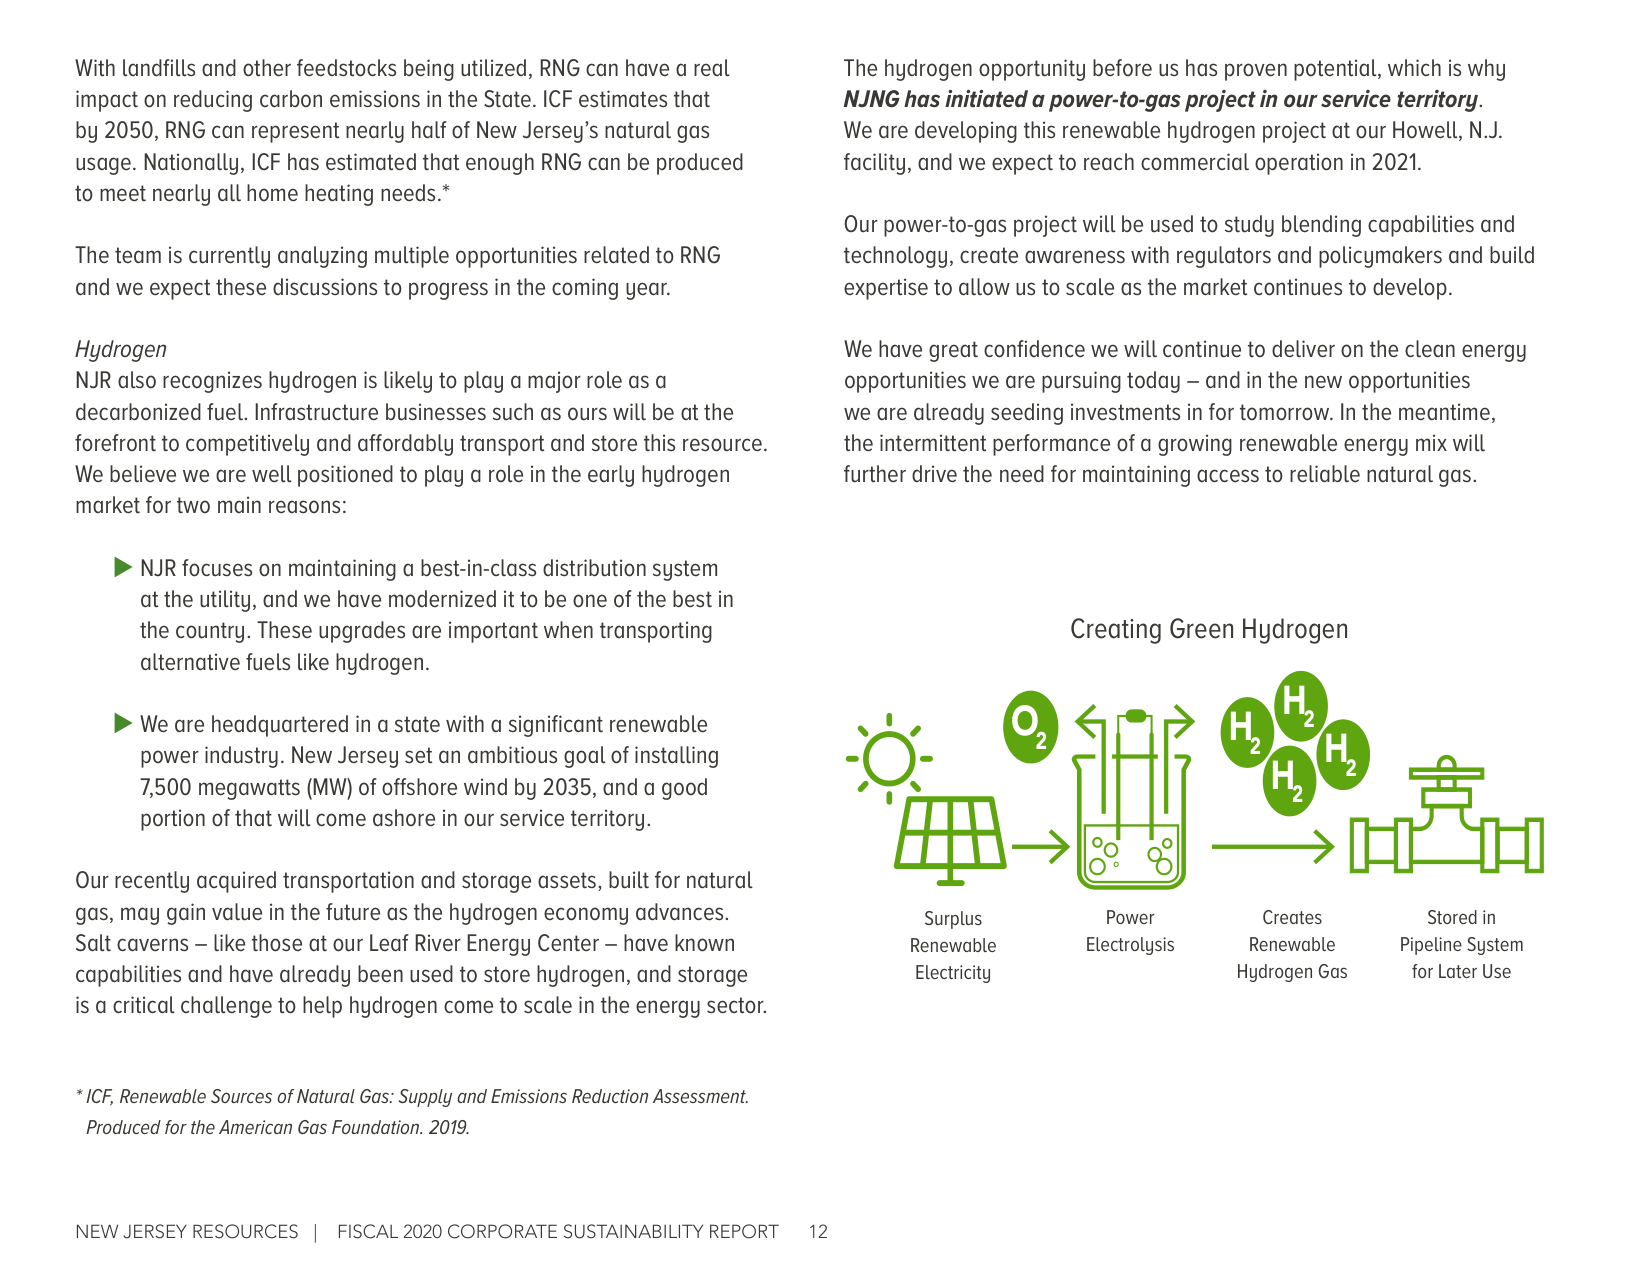

In [8]:
# test extract function
test_id = df.iloc[4]['id']

# extract content from the pdf page
test_content = extract_content_from_id(test_id)
print(test_content)

# render the page
render_content_from_id(test_id)
  

In [9]:
contents = []

# iterate over each page and extract content
for idx, row in tqdm(df.iterrows(), total=len(df)):
    # get file id
    file_id = row['id']
    # extract content from 
    content = extract_content_from_id(file_id)
    contents.append(content)
    
df['content'] = contents

  0%|          | 0/1951 [00:00<?, ?it/s]

In [10]:
df.head()

,id,class,content
1294,report_1132.pdf.10,environmental,Since 2014 The Nature Conservancy and our part...
196,report_1132.pdf.11,environmental,Leading the Way to Decarbonized Energy Future ...
626,report_1132.pdf.12,environmental,We are making real strides in support of the S...
661,report_1132.pdf.13,environmental,Our environmental record is excellent Neverthe...
1616,report_1132.pdf.14,environmental,The hydrogen opportunity before us has proven ...


# Basic Data Analysis

In [11]:
# create a new column with the report name
df['report_name'] = df['id'].apply(lambda x: x.split('.')[0])

# creat a new column with the page number
df['page_num'] = df['id'].apply(lambda x: x.split('.')[-1])

# reorder columns
df = df[['id','report_name', 'page_num', 'class', 'content']]


In [12]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1951 entries, 1294 to 1492
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1951 non-null   object
 1   report_name  1951 non-null   object
 2   page_num     1951 non-null   object
 3   class        1951 non-null   object
 4   content      1951 non-null   object
dtypes: object(5)
memory usage: 91.5+ KB


,id,report_name,page_num,class,content
1294,report_1132.pdf.10,report_1132,10,environmental,Since 2014 The Nature Conservancy and our part...
196,report_1132.pdf.11,report_1132,11,environmental,Leading the Way to Decarbonized Energy Future ...
626,report_1132.pdf.12,report_1132,12,environmental,We are making real strides in support of the S...
661,report_1132.pdf.13,report_1132,13,environmental,Our environmental record is excellent Neverthe...
1616,report_1132.pdf.14,report_1132,14,environmental,The hydrogen opportunity before us has proven ...


In [13]:
# save df locally to parquet
df.to_parquet(get_path(["process"], "data_v0.parquet"))

# save df locally to csv
df.to_csv(get_path(["process"], "data_v0.parquet"), index=False)

In [15]:
# count the number of unique reports
num_report = df['report_name'].nunique()
ic(num_report)

# find the median number of pages per report
median_page = df.groupby('report_name')['page_num'].nunique().median()
ic(median_page)

# find the 75th percentile of pages per report
percentile75_page = df.groupby('report_name')['page_num'].nunique().quantile(0.75)
ic(percentile75_page)

NameError: name 'ic' is not defined

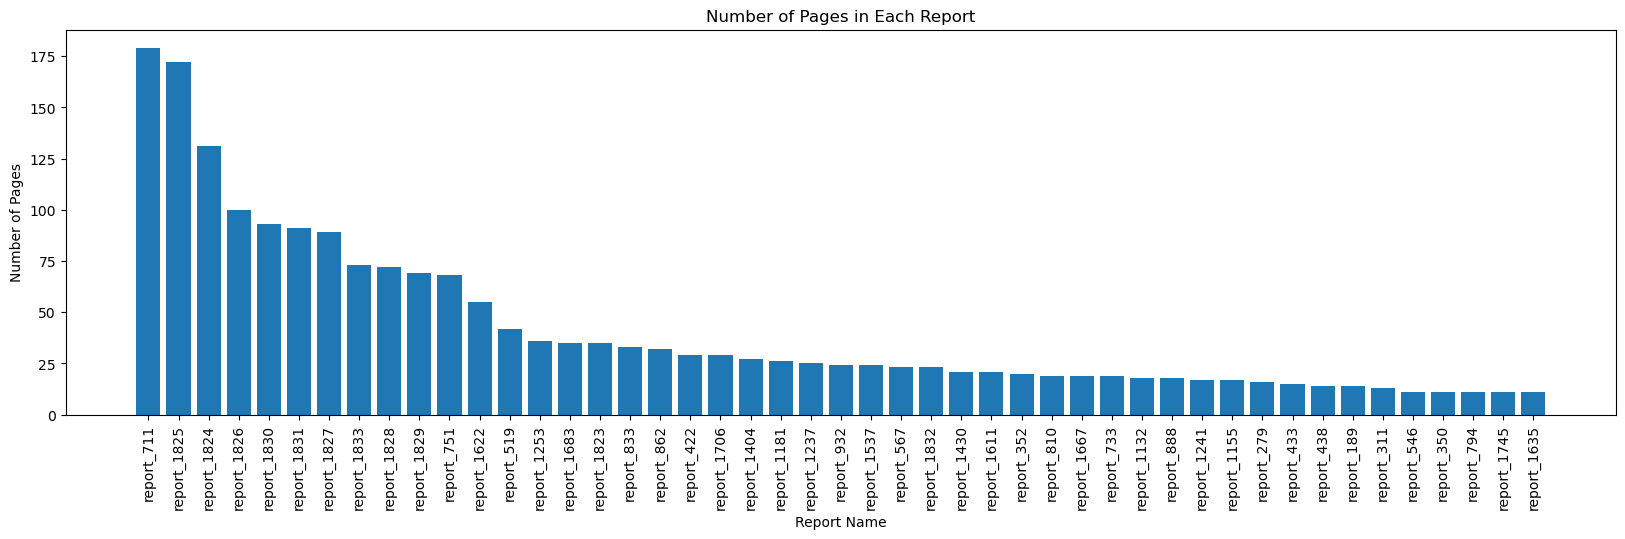

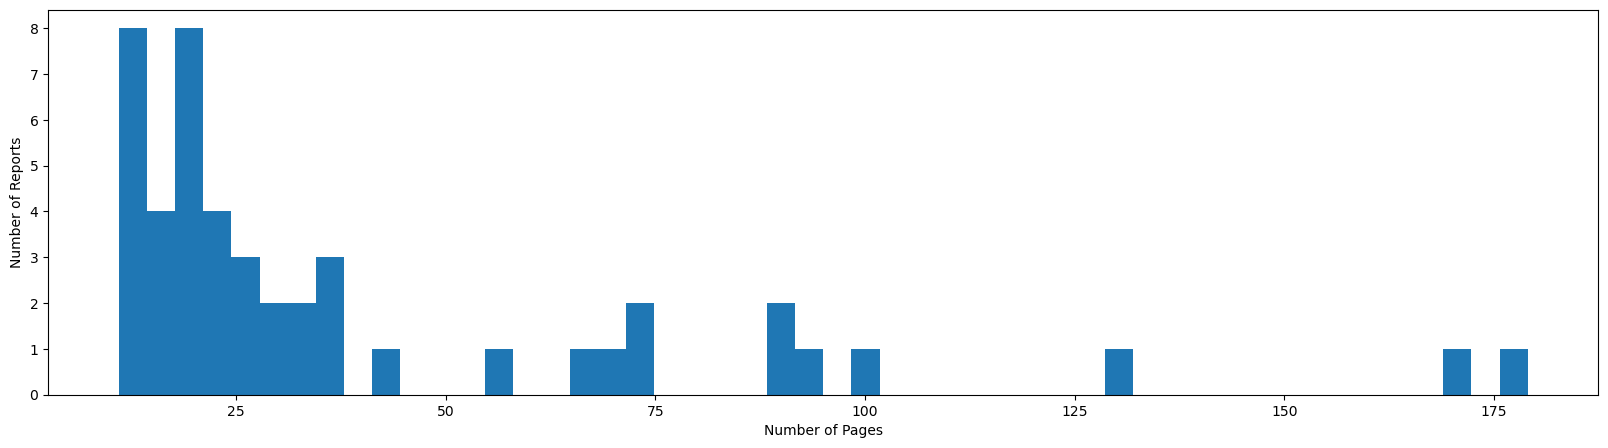

In [16]:

# plot the number of unique pages in each report using bar plot, order by number of pages
num_pages = df.groupby('report_name')['page_num'].nunique().sort_values(ascending=False)

# set the figure size, x and y axis labels, and plot the bar plot, tidy up the plot labels and title
plt.figure(figsize=(20,5))
plt.xlabel('Report Name')
plt.ylabel('Number of Pages')
plt.bar(num_pages.index, num_pages.values)
plt.xticks(rotation=90)
plt.title('Number of Pages in Each Report')
plt.show()


# plot the number of unique pages in each report using histogram
plt.figure(figsize=(20,5))
plt.xlabel('Number of Pages')
plt.ylabel('Number of Reports')
plt.hist(num_pages.values, bins=50)
plt.show()

In [17]:
# make dictionary for color mapping of each class
color_dict = {'environmental': 'green', 'governance': 'orange','social': 'red', 'other': 'blue'}

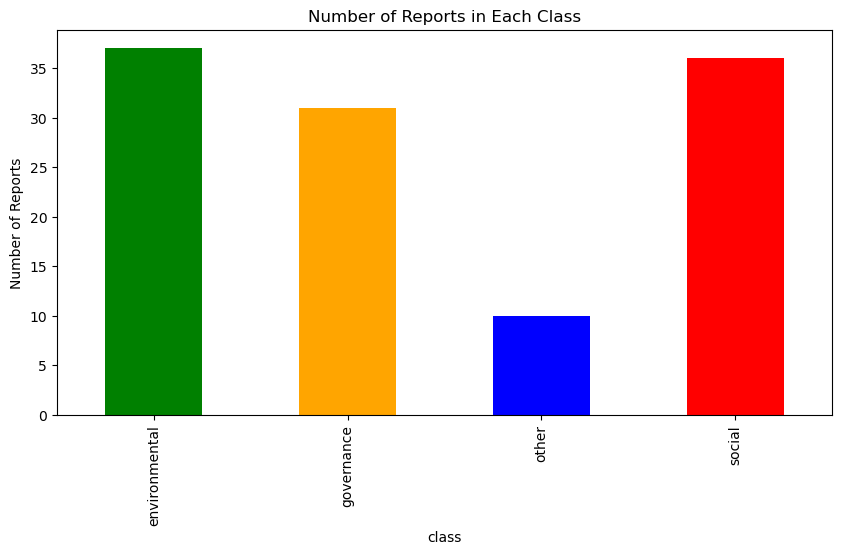

In [18]:
# group by classes and count the number of reports in each class
report_count = df.groupby('class')['report_name'].nunique()

# plot number of reports in each class using bar plot, different colors for each class
plt.figure(figsize=(10,5))
plt.xlabel('Class')
plt.ylabel('Number of Reports')
report_count.plot(kind='bar', color=[color_dict[i] for i in report_count.index])  
plt.title('Number of Reports in Each Class')
plt.show()

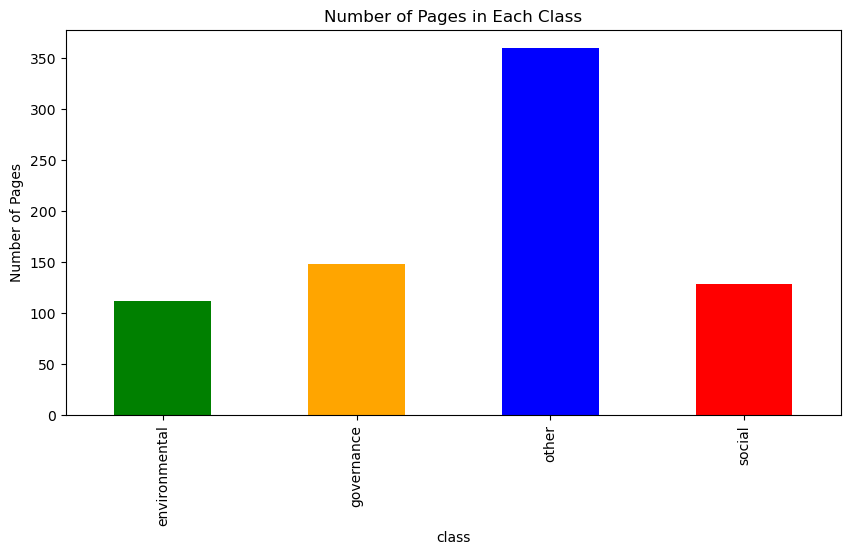

In [19]:
# plot number of pages in each class using bar plot, different colors for each class
plt.figure(figsize=(10,5))
plt.xlabel('Class')
plt.ylabel('Number of Pages')
df.groupby('class')['page_num'].nunique().plot(kind='bar', color=[color_dict[i] for i in report_count.index])  
plt.title('Number of Pages in Each Class')
plt.show()


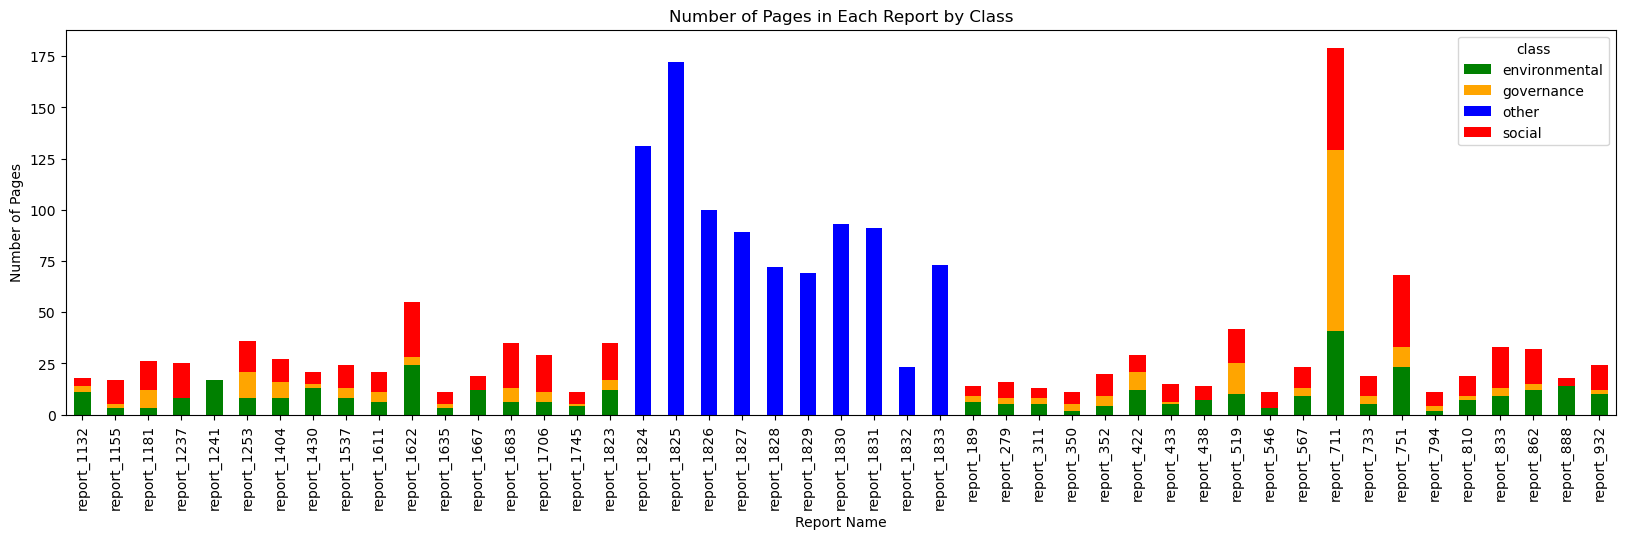

In [20]:
# group by report name, and count the number of pages in each class
num_pages_class = df.groupby('report_name')['class'].value_counts().unstack()

# plot a bar chart, highlight different classes with different colors within each bar
colors = ['green', 'orange', 'blue', 'red']
num_pages_class.plot(kind='bar', stacked=True, figsize=(20,5), color  = color_dict)
plt.xticks(rotation=90)
plt.xlabel('Report Name')
plt.ylabel('Number of Pages')
plt.title('Number of Pages in Each Report by Class')
plt.show()


### Insights at document-level
- 47 reports in total, 75% have less than 50 pages
- reports with more pages tend to have label 'other' (maybe artefact or training data)
- class equally distributed by report (a report can have multiple classes -E,-S,-G), except 'other' (is it a rule?)
- by pages: classes are skew, dominant class: 'other'. While the E/S/G classes are roughly equal
- by pages: total 'other' is roughly equal sum of all other classes

Issue: strategies may differ for document-level or page-level classification
- pages randomly drawn from a set of reports (rare to have 2 pages from same report)
- draw reports and classify all included pages (likely to have multiple pages from same reports)

Thoughts:
- should we learn document meta-features? probably not, have to be flexible at page-level
- need stratify when splitting (preserve classes distribution by pages/reports)

# Tokenize content for EDA

- number of tokens on each page
- class distribution by number of tokens

In [25]:
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import string
import re

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /Users/mbp14/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/mbp14/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mbp14/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
# build a function to preprocess text: tokenize, remove stopwords and punctuation, lemmatize
lem = WordNetLemmatizer()

def process_text(text):
  ''' function to perform text preprocessing for EDA, not for modelling purpose
  input: text
  output: list of word tokens
  '''
  
  # Tokenize the text
  tokens = word_tokenize(text.lower())
  
  # filter stopwords and punctuation
  tokens = [token for token in tokens if token not in stopwords.words('english') and token not in string.punctuation]

  # Lemmatize words
  tokens = [lem.lemmatize(token, "v") for token in tokens]
  
  # # stemming: reduce words to their root form, may lead to loss of context in small dataset 
  # # example: we want to keep sustain, sustainability, sustainable, under stemming they are the same
  # stemmer = PorterStemmer()
  # tokens = [stemmer.stem(token) for token in tokens]
  
  # Remove special characters and numbers from tokens
  tokens = [re.sub(r"[^a-zA-Z]+", '', token) for token in tokens]
  
  # Remove empty strings
  tokens = list(filter(None, tokens))

  # Remove token that are less than 1 character: cleaning up
  tokens = [token for token in tokens if len(token) > 1]

  return tokens


In [27]:
# test the function on test content
test_tokens = process_text(test_content)
test_tokens

['hydrogen',
 'opportunity',
 'us',
 'prove',
 'potential',
 'njng',
 'initiate',
 'power',
 'gas',
 'project',
 'service',
 'territory',
 'develop',
 'renewable',
 'hydrogen',
 'project',
 'howell',
 'nj',
 'facility',
 'expect',
 'reach',
 'commercial',
 'operation',
 'landfills',
 'feedstocks',
 'utilize',
 'rng',
 'real',
 'impact',
 'reduce',
 'carbon',
 'emissions',
 'state',
 'icf',
 'estimate',
 'rng',
 'represent',
 'nearly',
 'half',
 'new',
 'jersey',
 'natural',
 'gas',
 'usage',
 'nationally',
 'icf',
 'estimate',
 'enough',
 'rng',
 'produce',
 'meet',
 'nearly',
 'home',
 'heat',
 'need',
 'team',
 'currently',
 'analyze',
 'multiple',
 'opportunities',
 'relate',
 'rng',
 'expect',
 'discussions',
 'progress',
 'come',
 'year',
 'power',
 'gas',
 'project',
 'use',
 'study',
 'blend',
 'capabilities',
 'technology',
 'create',
 'awareness',
 'regulators',
 'policymakers',
 'build',
 'expertise',
 'allow',
 'us',
 'scale',
 'market',
 'continue',
 'develop',
 'great',
 '

In [28]:
# make a copy of the dataframe
df_eda = df.copy()

# apply the function to the whole dataframe on the content column
df_eda['tokens'] = df_eda['content'].apply(process_text)

In [29]:
# drop the content column
df_eda.drop('content', axis=1, inplace=True)

# add a new column: count the number of tokens in each row
df_eda['num_tokens'] = df_eda['tokens'].apply(lambda x: len(x))

In [30]:
# describe the distribution of number of tokens
df_eda['num_tokens'].describe()

count    1951.000000
mean      288.361353
std       155.698723
min         0.000000
25%       169.000000
50%       272.000000
75%       391.000000
max      1076.000000
Name: num_tokens, dtype: float64

In [31]:
# concatenate all tokens into a list
all_tokens = []
for tokens in df_eda['tokens']:
    all_tokens += tokens
    
# make the list of unique tokens
unique_tokens = list(set(all_tokens))

# describe the distribution of character length of unique tokens
unique_tokens_len = [len(token) for token in unique_tokens]

# concatenate unique tokens and their length into a dataframe
df_unique_tokens = pd.DataFrame({'token': unique_tokens, 'length': unique_tokens_len})

# describe the distribution of character length of unique tokens
df_unique_tokens.describe()

,length
count,18951.000000
mean,8.297346
std,7.391186
min,2.000000
25%,5.000000
50%,7.000000
75%,10.000000
max,138.000000


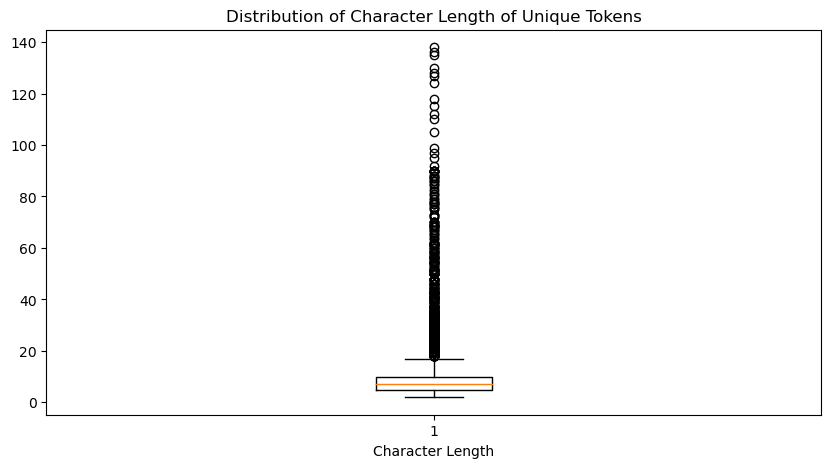

In [32]:
# plot the distribution of character length of unique tokens using boxplot
plt.figure(figsize=(10,5))
plt.xlabel('Character Length')
plt.boxplot(df_unique_tokens['length'])
plt.title('Distribution of Character Length of Unique Tokens')
plt.show()

# around 15 characters: indicative of parsing error

### Insights from tokenization

- some phrases are not parsed correctly: tokenizer or PDF parsing error
- PDF parsing is most important, then tokenizer
- text pre-processing trade-off, find balance

Strategies:
- sentent tokenizer then word tokenizer
- change order: clean up text first then tokenize
- try Keras and different tokenizers

In [33]:
# save df to local parquet file
df_eda.to_parquet(os.path.join(basepath, "process", "data_v1.parquet"), index=False)